# OnlineL Data Wrangling, Smoothing, and Trimming
Much of this notebook builds on brainIAK tutorial notebooks as well as my previous work in NEU/ELE 480 as well as builds upon Dr. Meir Meshulam's previous work with this data set, his sugestions for data wrangling, and other publicly available ISC/ISFC related notebooks.

Kumar, M., Anderson, M. J., Antony, J. W., Baldassano, C., Brooks, P. P., Cai, M. B., Chen, P.-H. C., Ellis, C. T., Henselman-Petrusek, G., Huberdeau, D., Hutchinson, J. B., Li, P. Y., Lu, Q., Manning, J. R., Mennen, A. C., Nastase, S. A., Richard, H., Schapiro, A. C., Schuck, N. W., Shvartsman, M., Sundaraman, N., Suo, D., Turek, J. S., Turner, D. M., Vo, V. A., Wallace, G., Wang, Y., Williams, J. A., Zhang, H., Zhu, X., Capota, M., Cohen, J. D., Hasson, U., Li, K., Ramadge, P. J., Turk-Browne, N. B., Willke, T. L., & Norman, K. A. (2021). BrainIAK: The Brain Imaging Analysis Kit. Aperture Neuro, 1(4). https://doi.org/10.52294/31bb5b68-2184-411b-8c00-a1dacb61e1da

In [52]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import os 
import glob
import time
from copy import deepcopy
# Import fMRI and general analysis libraries
import nibabel as nib
import numpy as np
import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
import scipy.spatial.distance as sp_distance
import sklearn
from sklearn.svm import NuSVC, LinearSVC
from sklearn import decomposition
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import deepdish as dd

# Import plotting library
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

# Import machine learning libraries
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV, PredefinedSplit
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import sem
from copy import deepcopy
from nilearn.masking import apply_mask


# load some helper functions
from utils import raider_data_dir, load_vdc_mask, load_vdc_epi_data, load_vdc_masked_data 
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run # load some constants

%matplotlib inline 
%autosave 5

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")
from utils import mask_data
from os import listdir, makedirs, walk, remove, getlogin, rename, system, sep, getcwd
from os.path import join, exists, isfile, getmtime, isdir
import numpy as np
import sklearn as sk
import nilearn as nii
from nilearn.plotting import view_img, view_img_on_surf, plot_roi, plot_epi, show
from nilearn import datasets
from nilearn.image import load_img, math_img,index_img
from nilearn.image import resample_img
from nilearn.image import resample_to_img
from time import time
from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc, phaseshift_isc, timeshift_isc, squareform_isfc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm

Autosaving every 5 seconds


##  Setting up directories  <a id="isc_isfc_wkflow"></a>


In [21]:
data_dir=f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep'
mask_dir=f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/masks'
ref = os.path.join(mask_dir,'Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')

In [3]:
sub_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
tasks = ['piemanVid', 'cosVid', 'histVid', 'piemanQA', 'cosQA', 'histQA']

##  Smoothing at scale <a id="isc_isfc_wkflow"></a>


In [298]:
cosVid_output_fnames = ['/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_02_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_03_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_04_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_05_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_06_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_07_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_08_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_09_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_10_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_11_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_12_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_13_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_14_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_15_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_16_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_17_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_18_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_19_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_20_cosVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_21_cosVid.nii.gz']

In [300]:
histVid_output_fnames = ['/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_02_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_03_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_04_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_05_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_06_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_07_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_08_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_09_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_10_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_11_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_12_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_13_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_14_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_15_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_16_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_17_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_18_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_19_histVid.nii.gz','/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_20_histVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_21_histVid.nii.gz']

In [296]:
piemanVid_output_fnames = ['/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_piemanVid.nii.gz' , '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_02_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_03_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_04_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_05_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_06_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_07_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_08_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_09_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_10_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_11_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_12_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_13_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_14_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_15_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_16_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_17_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_18_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_19_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_20_piemanVid.nii.gz', '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_21_piemanVid.nii.gz']

In [297]:
# doing this at scale for pieman videos 

from subprocess import run, PIPE
files = piemanVid_fnames
for i in range(len(files)):

# file definitions

    input_file = files[i]

    mask_file= mask_name

    output_file= piemanVid_output_fnames[i]

    log_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/smoothing_log.sh'

    if not exists(output_file):

        run(f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}', shell=True)

In [299]:
# doing this at scale for cos videos 

from subprocess import run, PIPE
files = cosVid_fnames
for i in range(len(files)):

# file definitions

    input_file = files[i]

    mask_file= mask_name

    output_file= cosVid_output_fnames[i]

    log_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/smoothing_log.sh'

    if not exists(output_file):

        run(f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}', shell=True)

In [301]:
# doing this at scale for hist videos 

from subprocess import run, PIPE
files = histVid_fnames
for i in range(len(files)):

# file definitions

    input_file = files[i]

    mask_file= mask_name

    output_file= histVid_output_fnames[i]

    log_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/smoothing_log.sh'

    if not exists(output_file):

        run(f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}', shell=True)

In [267]:
from subprocess import run, PIPE

input_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_01_piemanVid.nii.gz'

mask_file= mask_name

output_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_piemanVid.nii.gz'# a new filename of 1 but just in a dif place

log_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/smoothing_log.sh'

if not exists(output_file):

    run(f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}', shell=True)


In [ ]:
from subprocess import run, PIPE

input_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_01_piemanVid.nii.gz'

mask_file= mask_name

output_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_piemanVid.nii.gz'# a new filename of 1 but just in a dif place

log_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/smoothing_log.sh'

if not exists(output_file):

    run(f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}', shell=True)


In [273]:
smoothed_1 = nib.load('/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_piemanVid.nii.gz')

In [ ]:
# note image below needs to be meaned with a different axis, hense the dots


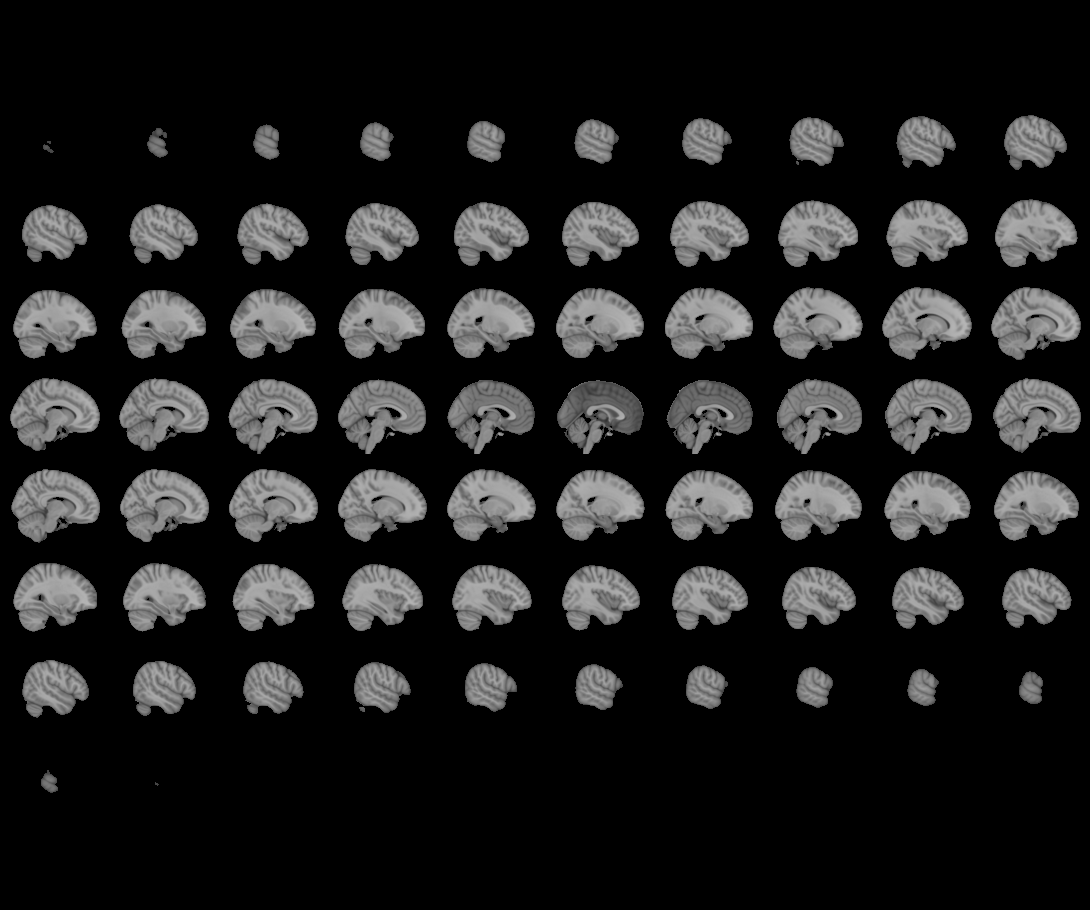
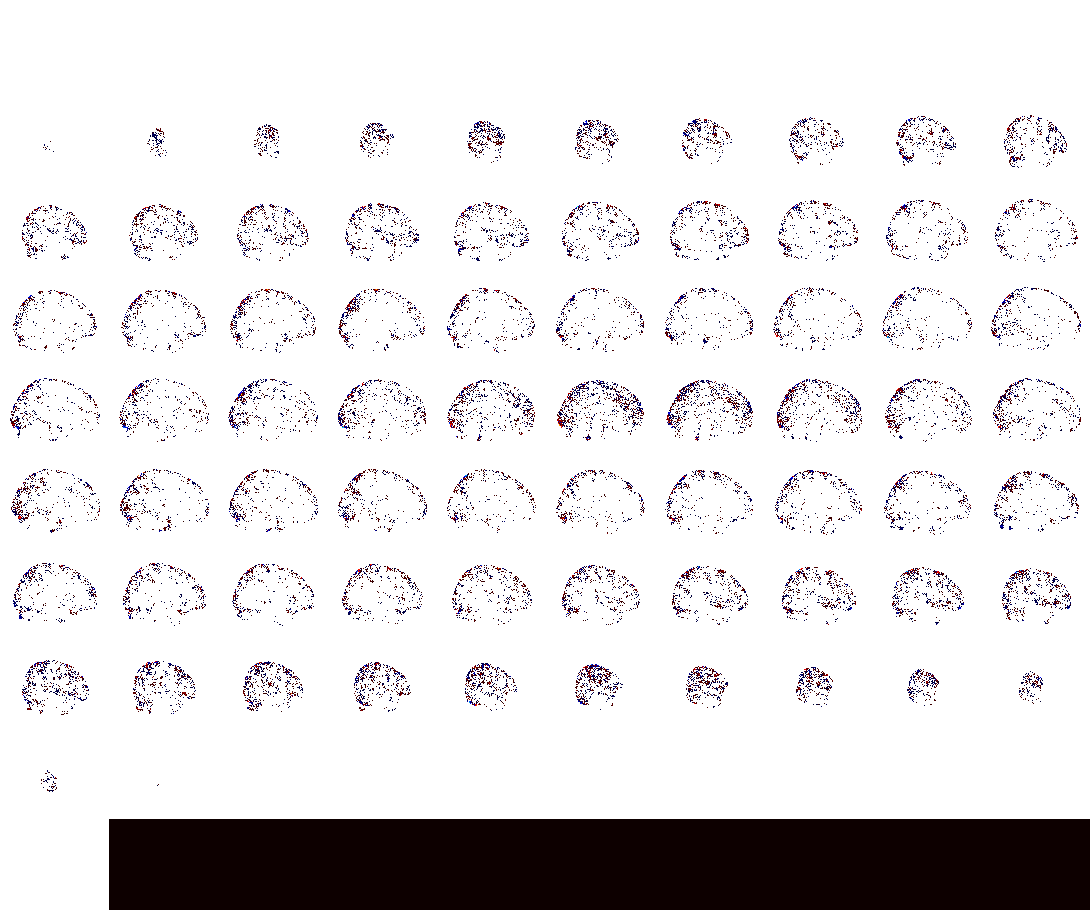

In [279]:
view_img(nii.image.mean_img(smoothed_1), title = 'Smoothed mean image for sub1 viewing piemanVid')

In [280]:
raw_1 = nib.load('/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_01_piemanVid.nii.gz')


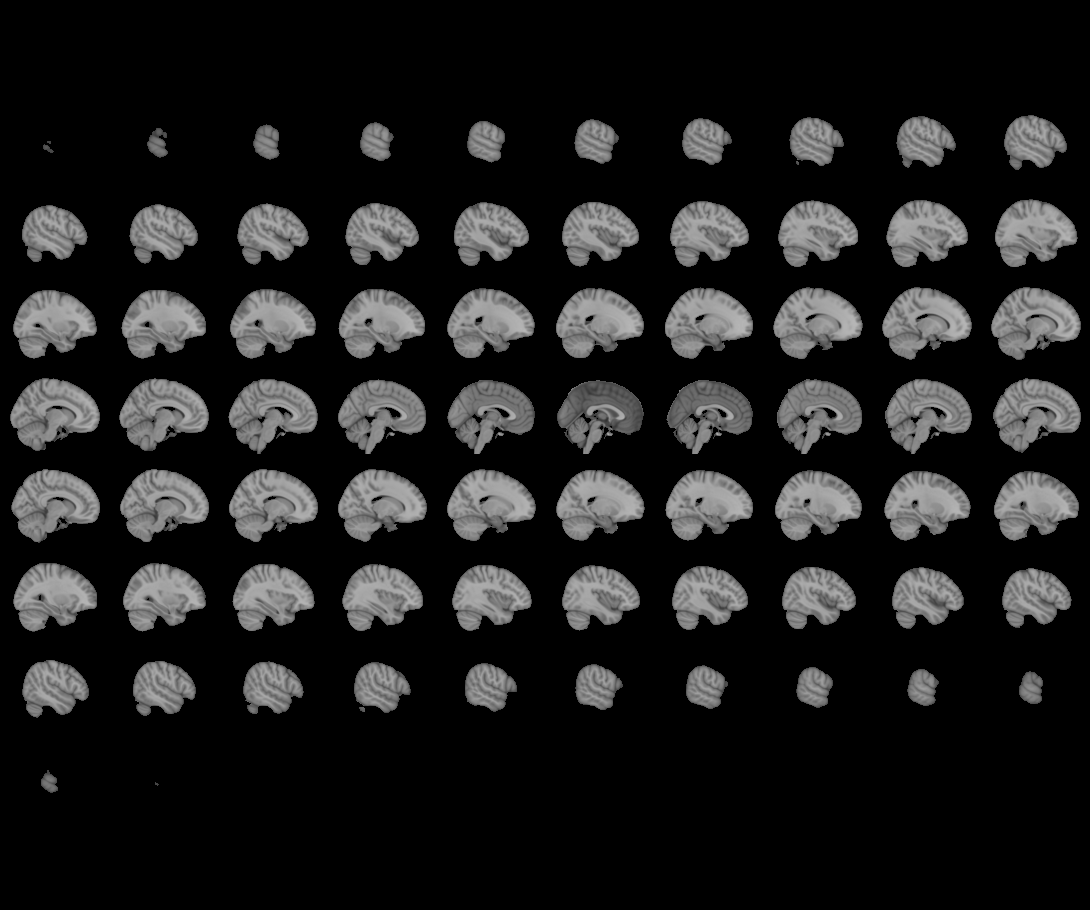
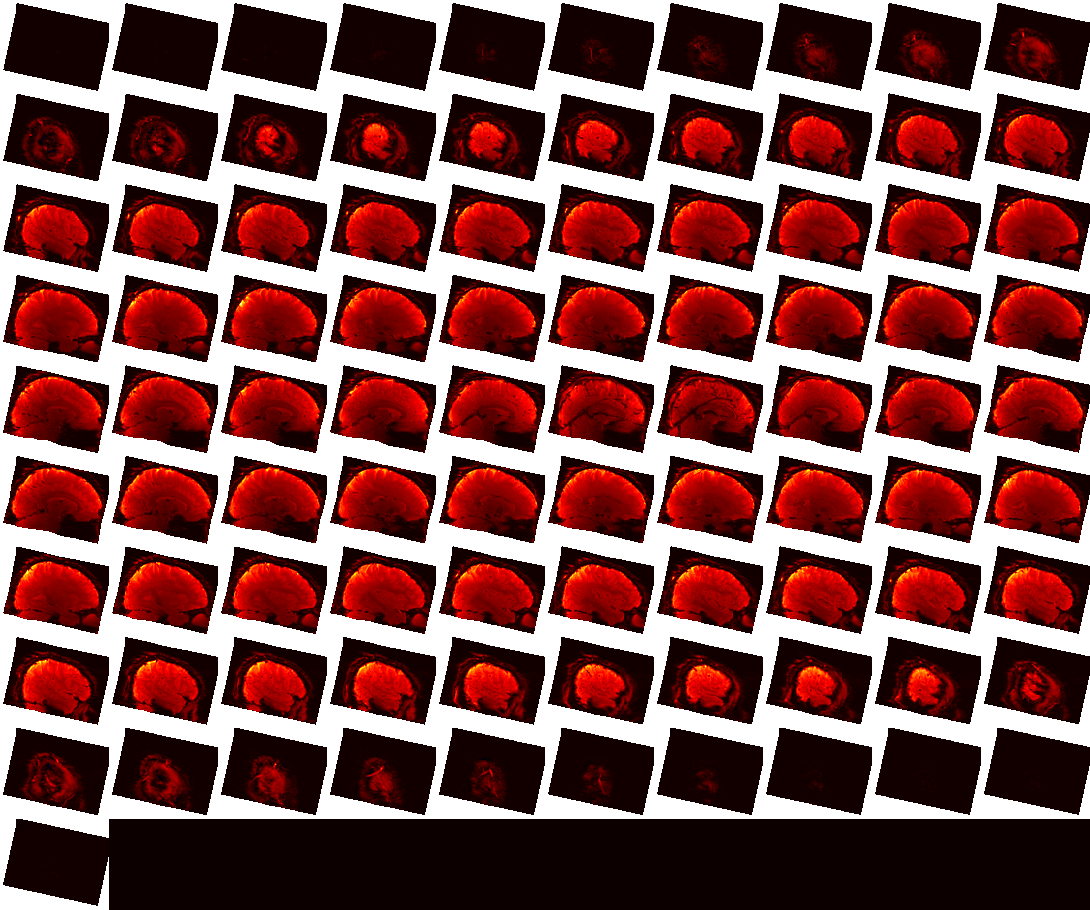

In [291]:
view_img(nii.image.mean_img(raw_1), title = 'UNsmoothed mean image for sub1 viewing piemanVid')

In [190]:
files = os.listdir('/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data')

In [ ]:
For i in range(len(files)):

# file definitions

    input_file= i

    mask_file= mask_name

    output_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/smoothed_data/smoothed_2mm_sub_01_piemanVid.nii.gz'# he filename of 1 but just n a different ace

    log_file= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/smoothing_log.sh'

# run script
    !/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}&



In [ ]:
file_name = '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_%s_%s.nii.gz' % (sub, task)
img_1 = nib.load(file_name)
input_file = img_1
brainmask = brain_nii

if not exists(output_file):

    !/mnt/cup/labs/hasson/daniellacohen/seniorResearch/seniorCode/Notebooks/detrend_and_smooth6mm_wafni.sh {input_file} {mask_file} {output_file} |& tee {log_file}&

##  Loading in files <a id="isc_isfc_wkflow"></a>


In [6]:
sub_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']

def fnames_all_subs(task):
    #locate the file
    fnames = []
    for i in sub_ids:
        fname = os.path.join(data_dir, 'resampled_data/resampled_2mm_sub_%s_%s.nii.gz' % (i, task))
        fnames.append(fname)
        
    return fnames

In [7]:
piemanVid_fnames = fnames_all_subs('piemanVid')
cosVid_fnames = fnames_all_subs('cosVid')
histVid_fnames = fnames_all_subs('histVid')

In [22]:
print("pieman file list contains this many files files:", len(piemanVid_fnames))

pieman file list contains this many files files: 21


#  Loading data and masking per subject <a id="isc_isfc_wkflow"></a>
### this was done to align TRs across subs

# Might need better mask and continue from here...

In [9]:
# NOW USING neurovault - might need a better one
"""load brain template"""
# NOTE that below when I show individual mask files, I load the bool mask as a separate step and call it _bool_mask
# next I should optimize my code and make a function that takes in the mask file, task file names, task and extracts
# images and bold data this all in one step
mask_name = f'/mnt/cup/labs/hasson/daniellacohen/seniorResearch/masks/MNI152_T1_2mm_brain_mask.nii.gz' #downloaded from neurovault
# Load the brain mask
brain_mask = io.load_boolean_mask(mask_name)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Load the brain nii image
brain_nii = nib.load(mask_name)


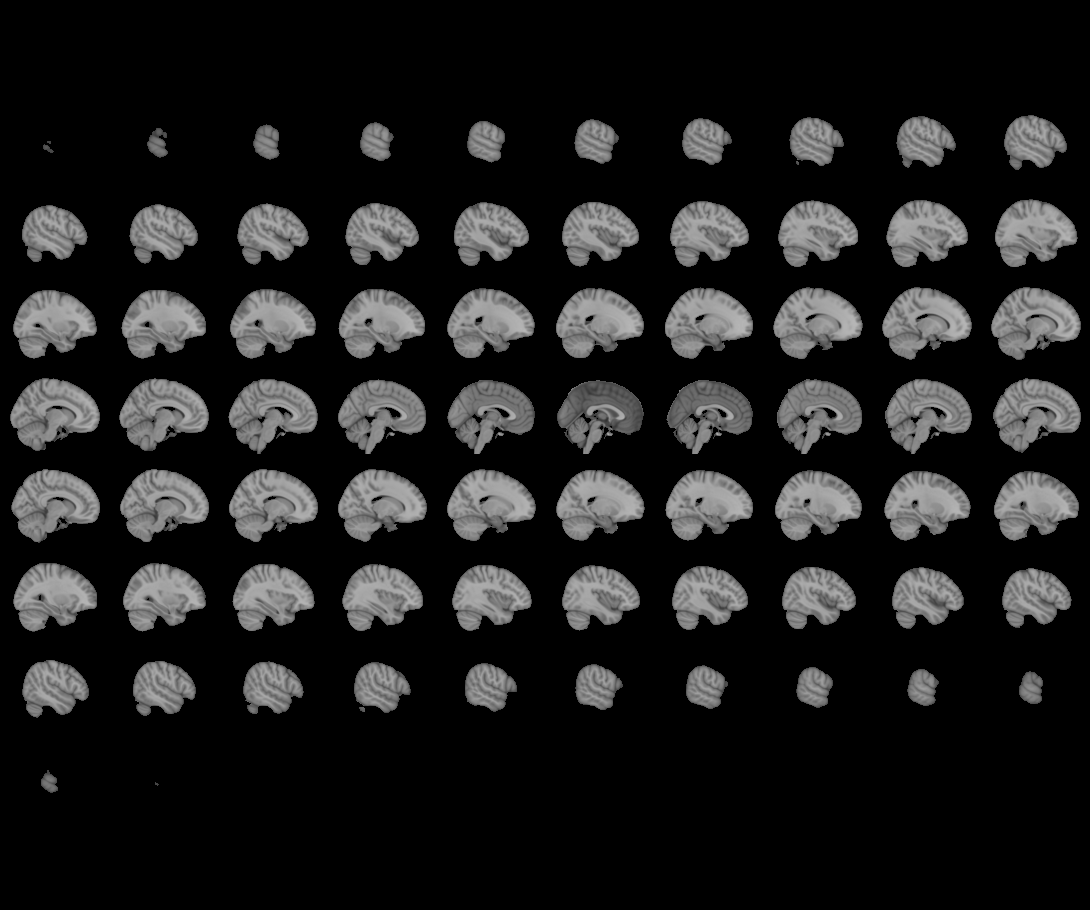
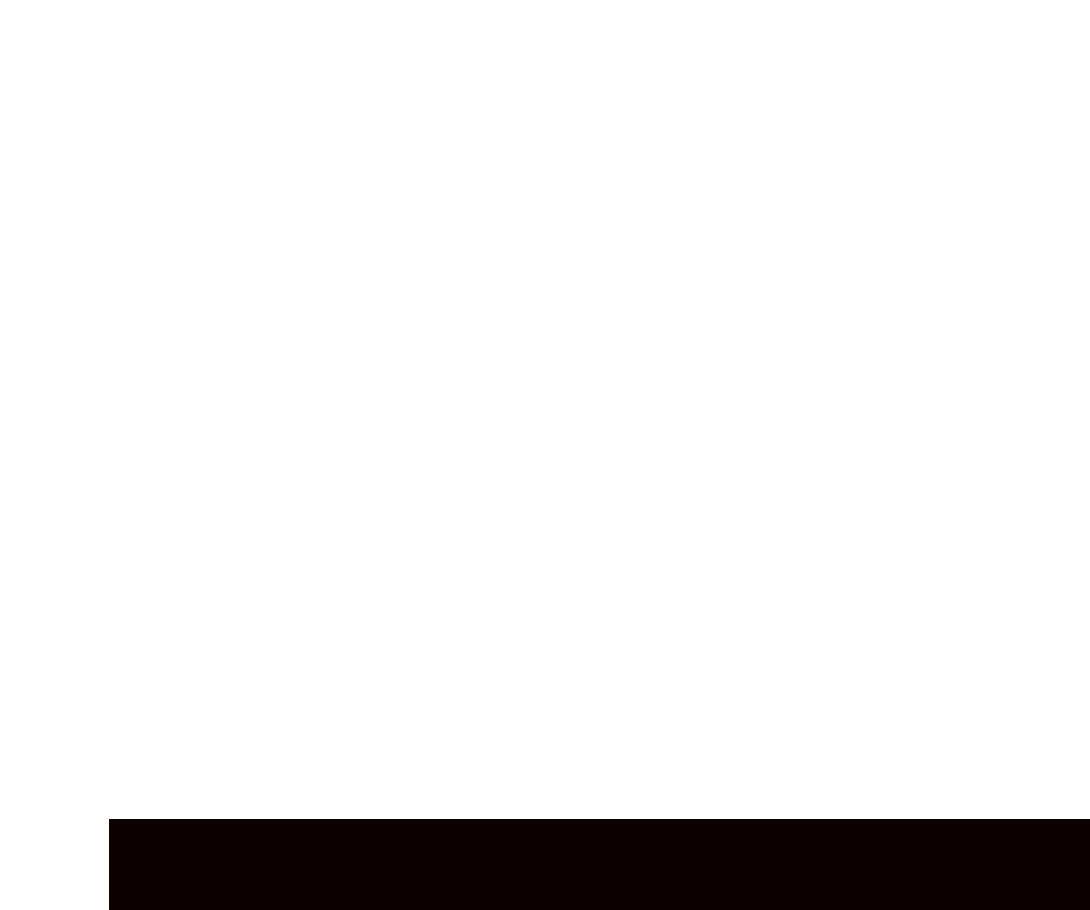

In [14]:
view_img(brain_nii)

In [167]:
brain_nii.shape

(91, 109, 91)

In [ ]:
# what I should do
# load the fdata, then trim then save as an niigz file, then go back to brainiak

In [ ]:
# either load in across files, or per subject - similar to resampling

In [ ]:
def load_one_sub(sub, task):
    file_name = '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/resampled_2mm_sub_%s_%s.nii.gz' % (sub, task)
    img = nib.load(file_name)
    bold = img.get_fdata()
    mean_bold = np.mean(bold, axis = -1)
    mean_img=nii.image.mean_img(img)
    return bold, mean_bold, img, mean_img

In [31]:
# trimming pieman
# saving trimmed image
piemanVid_wb_bold_trimmed = []
for i in range(len(piemanVid_wb_images)):
    piemanVid_wb_bold_trimmed.append(piemanVid_wb_images[i][4:284,:])
    save_name= '/mnt/cup/labs/hasson/daniellacohen/seniorResearch/derivatives/fmriprep/resampled_data/trimmed_resampled_data'
    resampled_img.to_filename(save_name + '_sub_%s_%s.nii.gz' % (sub, task))

In [26]:
# Ssving trimmed images
#load images and bold data
# making a function out of the blocks below, still need to trim, and make this actually resaving files. will do that after

#1. load the image data
#2. mask the images individually
#3. get the bold data
#3. crop the bold data

def load_img_bold(filename):
        
    images = []
    fnames = filename
    whole_brain_masked_images = []
    whole_brain_bold = [] 

#images = io.load_images(fnames)  
    for filename in fnames:
        images.append(nib.load(filename))
    for image in images:
        whole_brain_masked_images.append(apply_mask(image, brain_nii))
        
    return whole_brain_masked_images


    

In [26]:
# load images and bold data
# making a function out of the blocks below, still need to trim, and make this actually resaving files. will do that after

#1. load the image data
#2. mask the images individually
#3. get the bold data
#3. crop the bold data

def load_img_bold(filename):
        
    images = []
    fnames = filename
    whole_brain_masked_images = []
    whole_brain_bold = [] 

#images = io.load_images(fnames)  
    for filename in fnames:
        images.append(nib.load(filename))
    for image in images:
        whole_brain_masked_images.append(apply_mask(image, brain_nii))
        
    return whole_brain_masked_images
    

In [27]:
# load in the data for pieman video
piemanVid_wb_images = load_img_bold(piemanVid_fnames)

In [92]:
np.mean(piemanVid_wb_images, axis = 0)

21

In [29]:
len(piemanVid_wb_images)

21

In [30]:
piemanVid_wb_images[1].shape

(286, 228483)

In [31]:
# trimming pieman
piemanVid_wb_bold_trimmed = []
for i in range(len(piemanVid_wb_images)):
    piemanVid_wb_bold_trimmed.append(piemanVid_wb_images[i][4:284,:])

In [32]:
piemanVid_wb_bold = np.asarray(piemanVid_wb_bold_trimmed).T.swapaxes(0,1) 

In [33]:
piemanVid_wb_bold.shape

(280, 228483, 21)

In [34]:
for i in range(21):
    print(piemanVid_wb_bold[:,:,i].shape)

(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)
(280, 228483)


In [35]:
# load in the data for hist video
histVid_wb_images = load_img_bold(histVid_fnames)

In [36]:
print("the length of of hist images is ", len(histVid_wb_images), "and for sub2 has shape", histVid_wb_images[1].shape)

the length of of hist images is  21 and for sub2 has shape (351, 228483)


In [37]:
# trimming history
histVid_wb_bold_trimmed = []
for i in range(len(histVid_wb_images)):
    histVid_wb_bold_trimmed.append(histVid_wb_images[i][4:350,:])

In [38]:
histVid_wb_bold = np.asarray(histVid_wb_bold_trimmed).T.swapaxes(0,1) 

In [39]:
histVid_wb_bold.shape

(346, 228483, 21)

In [40]:
for i in range(21):
    print(histVid_wb_bold[:,:,i].shape)

(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)
(346, 228483)


In [41]:
# load in the data for cos video
cosVid_wb_images = load_img_bold(cosVid_fnames)

In [42]:
print("the length of of cos images is ", len(cosVid_wb_images), "and for sub2 has shape", cosVid_wb_images[1].shape)

the length of of cos images is  21 and for sub2 has shape (276, 228483)


In [43]:
# trimming cos
cosVid_wb_bold_trimmed = []
for i in range(len(cosVid_wb_images)):
    cosVid_wb_bold_trimmed.append(cosVid_wb_images[i][4:276,:])

In [44]:
cosVid_wb_bold = np.asarray(cosVid_wb_bold_trimmed).T.swapaxes(0,1) 

In [45]:
cosVid_wb_bold.shape

(272, 228483, 21)

In [46]:
for i in range(21):
    print(cosVid_wb_bold[:,:,i].shape)

(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)
(272, 228483)


##  ISC all subjects
### This exemplifies the difference between smoother and unsmoothed ISC


In [35]:
piemanVid_isc_map = brainiak.isc.isc(piemanVid_wb_bold, pairwise=False, tolerate_nans=True)

In [58]:
piemanVid_isc_map_2 = brainiak.isc.isc(piemanVid_wb_bold, pairwise=False)

In [59]:
piemanVid_isc_map_2.shape

(21, 228483)

In [37]:
# set params 
subj_id = 0
task_name = 'piemanVid'
save_data = False

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = piemanVid_isc_map[subj_id, :]
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Save the ISC data as a volume
#if save_data: 
#    isc_map_path = os.path.join(dir_out, 'ISC_%s_sub%.2d.nii.gz' % (task_name, subj_id))
#    nib.save(isc_nifti, isc_map_path)

Text(0.5, 1.0, 'ISC map for subject 1, pieman video')

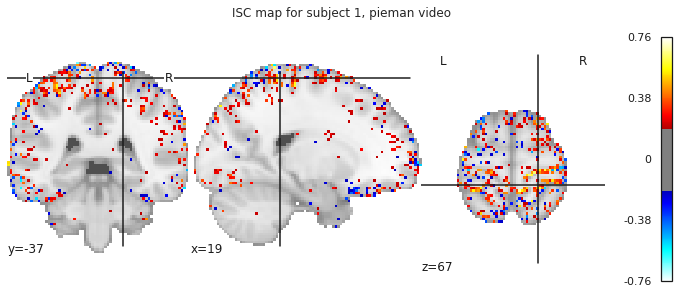

In [38]:
# Plot the data as a statmap
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title('ISC map for subject 1, pieman video')

In [45]:
    # Make the ISC output a volume
isc_vol_2 = np.zeros(brain_nii.shape)
    # Map the ISC data for the first participant into brain space
isc_vol_2[coords] = np.mean(piemanVid_isc_map_2, axis = 0)
    # make a nii image of the isc map 
mean_isc_nifti_2 = nib.Nifti1Image(isc_vol_2, brain_nii.affine, brain_nii.header)


Text(0.5, 1.0, 'Smoothed Average ISC map for piemanVid for all subs')

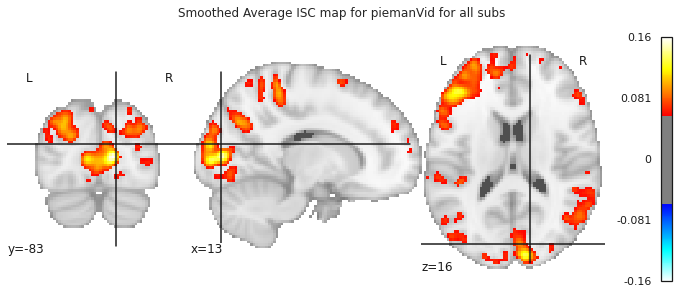

In [126]:
thresh = .06
smooth_mm = 6

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    img.smooth_img(mean_isc_nifti_2, smooth_mm), 
    threshold=thresh, 
    axes=ax
#   , display_mode = 'y'
)
ax.set_title('Smoothed Average ISC map for piemanVid for all subs') 

In [66]:
fsaverage = datasets.fetch_surf_fsaverage()

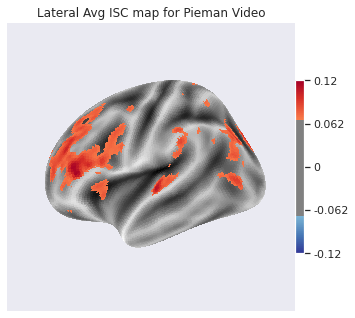

In [127]:
#lateral
smooth_mm = 6
mean_piemanVid_texture = surface.vol_to_surf(img.smooth_img(mean_isc_nifti_2, smooth_mm) , fsaverage.pial_left)

thresh = .07 
view = 'lateral'

# plot 
title_text = ('Lateral Avg ISC map for Pieman Video')
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, mean_piemanVid_texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=thresh, cmap='RdYlBu_r', 
    colorbar=True,
    bg_map=fsaverage.sulc_left)

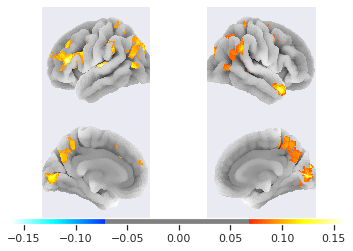

In [128]:
thresh = .07
smooth_mm = 6

plotting.plot_img_on_surf(img.smooth_img(mean_isc_nifti_2, smooth_mm),
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold = thresh,
                          colorbar=True)
plotting.show()

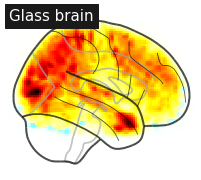

In [129]:
smooth_mm = 6
plotting.plot_glass_brain(img.smooth_img(mean_isc_nifti_2, smooth_mm), display_mode='r', plot_abs=False,
                          title='Glass brain', threshold=0)

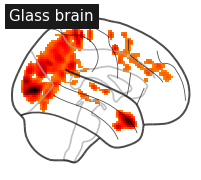

In [131]:
smooth_mm = 6
plotting.plot_glass_brain(img.smooth_img(mean_isc_nifti_2, smooth_mm), display_mode='r', plot_abs=False,
                          title='Glass brain', threshold=.07)

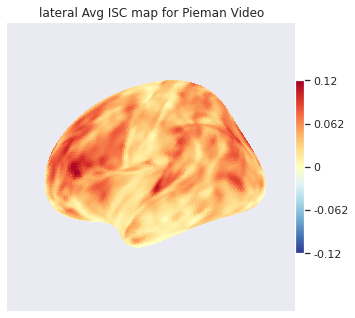

In [136]:
#Medial
smooth_mm = 6
mean_piemanVid_texture = surface.vol_to_surf(img.smooth_img(mean_isc_nifti_2, smooth_mm) , fsaverage.pial_left)

thresh = 0 
view = 'lateral'

# plot 
title_text = ('lateral Avg ISC map for Pieman Video')
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, mean_piemanVid_texture, 
    hemi='left', view=view, 
    title= title_text, 
    threshold=thresh, cmap='RdYlBu_r', 
    colorbar=True,
    bg_map=fsaverage.sulc_left)

In [140]:
smooth_mm = 6
thresh = "90%" 
mean_piemanVid_texture = surface.vol_to_surf(img.smooth_img(mean_isc_nifti_2, smooth_mm) , fsaverage.pial_left)

view = plotting.view_surf(fsaverage.infl_left, mean_piemanVid_texture, 
                          bg_map=fsaverage.sulc_left, threshold = thresh)
view